# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

Using TensorFlow backend.


In [2]:
def surface(
        x_grid, y_grid, z_grid,
        cmap="Blues", angle=(25, 300), alpha=1.,
        fontsize=14, labelpad=10,
        title="", x_label="", y_label="", z_label="log_likelihood"):
    """
    Creates 3d contour plot given a grid for each axis.
    Arguments:
    ``x_grid``
        An NxN grid of values.
    ``y_grid``
        An NxN grid of values.
    ``z_grid``
        An NxN grid of values. z_grid determines colour.
    ``cmap``
        (Optional) Colour map used in the plot
    ``angle``
        (Optional) tuple specifying the viewing angle of the graph
    ``alpha``
        (Optional) alpha parameter of the surface
    ``fill``
        (Optional) Used to specify whether or not contour plot should be filled
        Default False.
    ``fontsize``
        (Optional) the fontsize used for labels
    ``labelpad``
        (Optional) distance of axis labels from the labels
    ``x_label``
        (Optional) The label of the x-axis
    ``y_label``
        (Optional) The label of the y-axis
    ``z_label``
        (Optional) The label of the z-axis
    Returns a ``matplotlib`` figure object and axes handle.
    """
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D 
    ax = plt.axes(projection='3d')
    # Data for a three-dimensional line
    ax.plot_surface(x_grid, y_grid, z_grid, cmap=cmap, alpha=alpha)
    ax.view_init(*angle)

    fontsize = fontsize
    labelpad = labelpad

    if title:
        plt.title(title, fontsize=fontsize)
    if x_label:
        ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
    if y_label:
        ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
    if z_label:
        ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

    return ax

Next, I create a model class using the "Logistic" toy model included in pints:

In [3]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [4]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [5]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [6]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [7]:
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

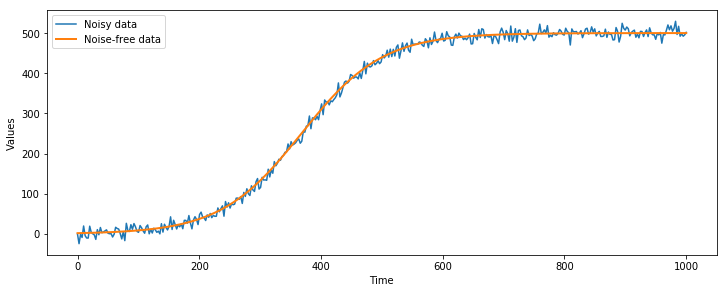

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [9]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [10]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

The resulting noise has mean zero and an unknown standard deviation. The standard deviation can be inferred along with the other parameters, meaning the number of parameters of the problem increased by one!

In [11]:
print('Original number of parameters: ' + str(problem.n_parameters()))

Original number of parameters: 2


In [12]:
print('New number of parameters: ' + str(log_likelihood.n_parameters()))

New number of parameters: 2


This means the vector of true parameters has to be updated:

In [13]:
#true_parameters += [noise]
print(true_parameters)

[0.015, 500]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [14]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [15]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [16]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [17]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0          0:00.0
2     9      0.333     0         0          0:00.0
3     12     0.25      0         0          0:00.0
20    63     0.0952    0.0476    0          0:00.0
40    123    0.0488    0.0244    0.0244     0:00.0
60    183    0.0492    0.0164    0.0328     0:00.0
80    243    0.0494    0.0123    0.037      0:00.0
100   303    0.0495    0.0099    0.0297     0:00.1
120   363    0.0413    0.00826   0.0248     0:00.1
140   423    0.0426    0.00709   0.0284     0:00.1
160   483    0.0435    0.0124    0.0311     0:00.1
180   543    0.0387    0.011     0.0276     0:00.1
Initial phase completed.
200   603    0.0348    0.00995   0.0249     0:00.1
220   663    0.0407    0.0226    0.0271     0:00.1
240   723    0.0664    0.0498    0.0456     0:00.1
260   783   

3140  9423   0.243     0.243     0.258      0:02.0
3160  9483   0.244     0.242012  0.258      0:02.0
3180  9543   0.243     0.241     0.257      0:02.0
3200  9603   0.242     0.241     0.256      0:02.0
3220  9663   0.242     0.240919  0.257063   0:02.0
3240  9723   0.240975  0.24      0.257      0:02.0
3260  9783   0.242     0.241     0.255      0:02.1
3280  9843   0.242     0.24      0.256      0:02.1
3300  9903   0.241442  0.24      0.255983   0:02.1
3320  9963   0.242     0.24      0.255      0:02.1
3340  10023  0.243041  0.24      0.255      0:02.1
3360  10083  0.242     0.239512  0.254091   0:02.1
3380  10143  0.242     0.238     0.254      0:02.1
3400  10203  0.24      0.24      0.253      0:02.1
3420  10263  0.239     0.24      0.253      0:02.2
3440  10323  0.238884  0.239     0.253      0:02.2
3460  10383  0.238     0.241     0.252      0:02.2
3480  10443  0.239     0.24      0.253      0:02.2
3500  10503  0.239     0.24      0.251      0:02.2
3520  10563  0.239     0.24    

6680  20043  0.236     0.236     0.241      0:04.2
6700  20103  0.236     0.236     0.24       0:04.2
6720  20163  0.235828  0.236     0.24       0:04.2
6740  20223  0.236     0.23587   0.24       0:04.3
6760  20283  0.237     0.236     0.24       0:04.3
6780  20343  0.237     0.235511  0.24       0:04.3
6800  20403  0.236     0.236     0.24       0:04.3
6820  20463  0.236     0.235     0.241      0:04.3
6840  20523  0.235     0.235     0.24       0:04.3
6860  20583  0.235     0.236     0.241      0:04.3
6880  20643  0.235     0.236     0.241      0:04.3
6900  20703  0.235     0.236     0.24       0:04.4
6920  20763  0.235     0.236     0.241      0:04.4
6940  20823  0.235     0.235845  0.239879   0:04.4
6960  20883  0.235     0.236     0.24       0:04.4
6980  20943  0.235     0.236     0.239937   0:04.4
7000  21003  0.235     0.236     0.239      0:04.4
7020  21063  0.235     0.236     0.239567   0:04.4
7040  21123  0.235     0.236188  0.239      0:04.4
7060  21183  0.235     0.236   

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

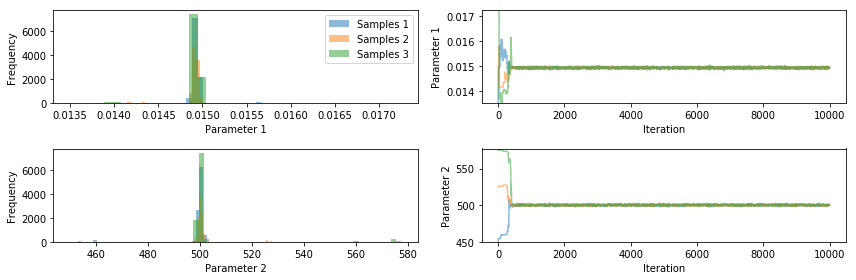

In [18]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [19]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

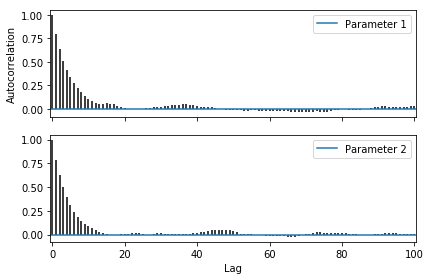

In [20]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

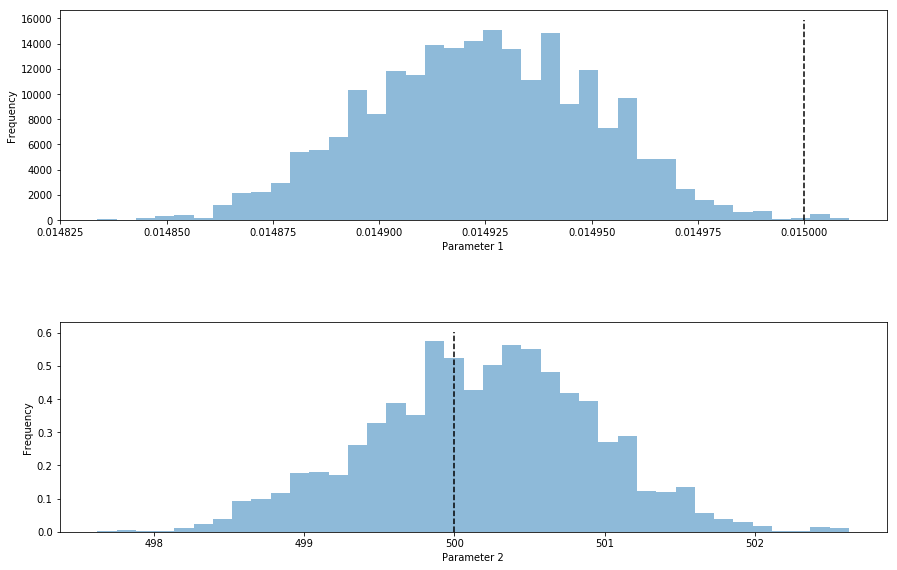

In [21]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [22]:
chain = chain[::10]

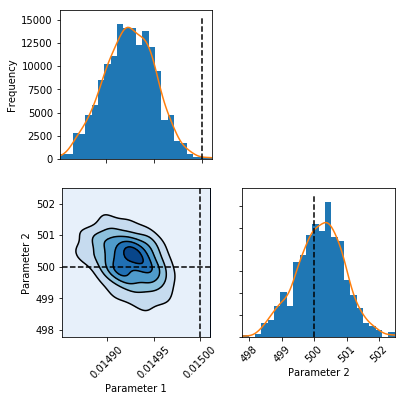

In [23]:
pints.plot.pairwise(chain, kde=True, ref_parameters=true_parameters)
plt.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line). 
But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.
To find out what's going on, we can plot the log-posterior function near the true parameters:

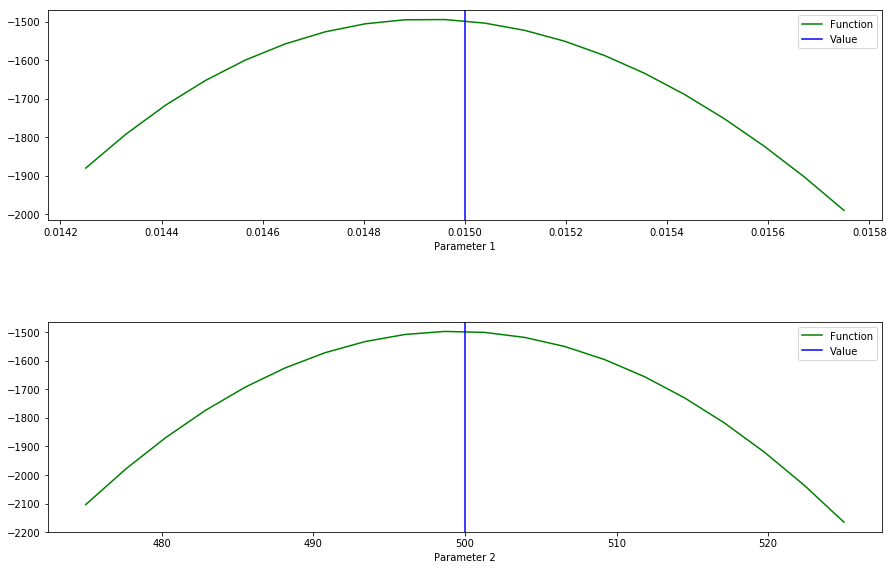

In [24]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

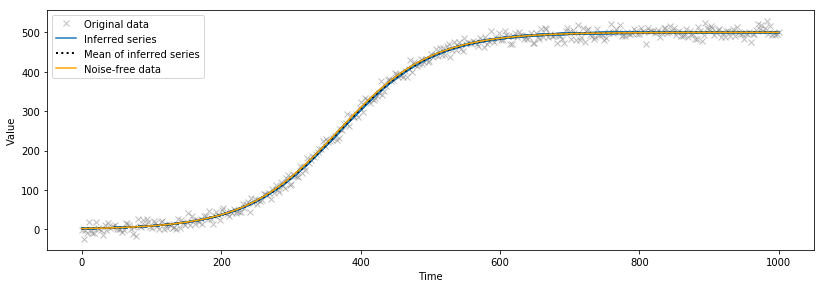

In [25]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

In [26]:
input_parameters = log_prior.sample(1000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
#input_parameters[:5]
input_parameters.shape

(1000, 2)

In [27]:
likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

array([ -3001.35663375, -42561.82358547, -14768.69968868, -28517.7467073 ,
       -13165.11776799])

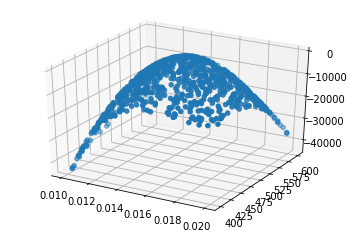

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [29]:
emu = pints.SingleLayerNN(log_likelihood, input_parameters, likelihoods)
emu.set_parameters(neurons=16, activation='softmax', hidden_activation='tanh')
hist = emu.fit(epochs=5, batch_size=1)
#emu.summary()
#print(hist.history.keys())

Train on 800 samples, validate on 200 samples
Epoch 1/5
800/800 [==============================] - 1s 813us/step - loss: 203433485.8406 - mean_squared_error: 203433485.8406 - mean_absolute_error: 11571.7597 - val_loss: 192462550.2925 - val_mean_squared_error: 192462550.2925 - val_mean_absolute_error: 11467.9435
Epoch 2/5
800/800 [==============================] - 1s 650us/step - loss: 203433485.8406 - mean_squared_error: 203433485.8406 - mean_absolute_error: 11571.7597 - val_loss: 192462550.2925 - val_mean_squared_error: 192462550.2925 - val_mean_absolute_error: 11467.9435
Epoch 3/5
800/800 [==============================] - 1s 673us/step - loss: 203433485.8406 - mean_squared_error: 203433485.8406 - mean_absolute_error: 11571.7597 - val_loss: 192462550.2925 - val_mean_squared_error: 192462550.2925 - val_mean_absolute_error: 11467.9435
Epoch 4/5
800/800 [==============================] - 1s 668us/step - loss: 203433485.8406 - mean_squared_error: 203433485.8406 - mean_absolute_error: 115

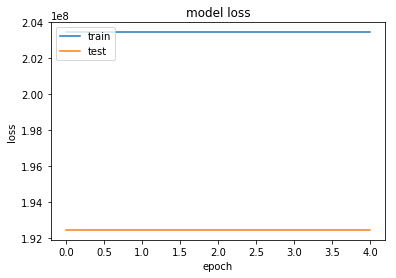

In [30]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#print(hist.history['loss'])
#print(hist.history['val_loss'])

In [31]:
emu([0.015, 500])

array([[1.]], dtype=float32)

20


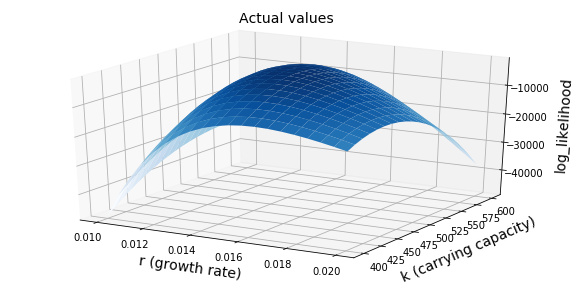

In [32]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)
print(len(test_data[0]))

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = surface(r_grid, k_grid, model_prediction, title = "Actual values",
                     x_label = "r (growth rate)",
                     y_label = "k (carrying capacity)")

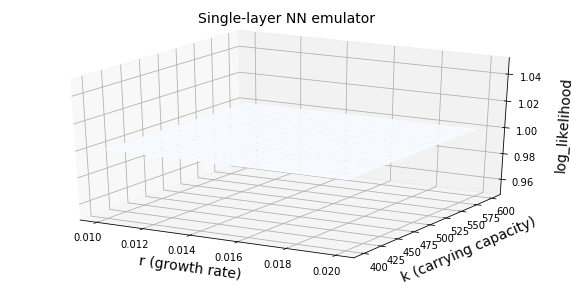

In [33]:
emu_prediction = pints.predict_grid(emu, test_data)
plt.figure(figsize = (10, 5))
ax = surface(r_grid, k_grid, emu_prediction, title = "Single-layer NN emulator",
                    x_label = "r (growth rate)", y_label = "k (carrying capacity)")

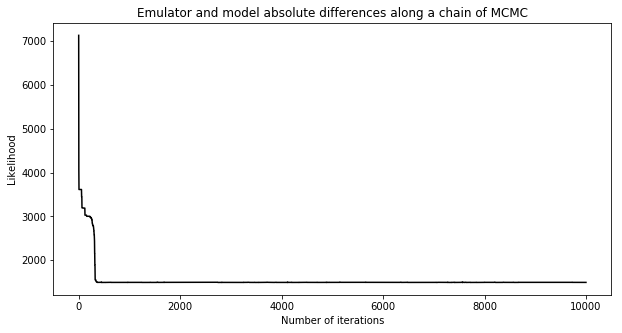

1494.7808704722418


In [34]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()
print(diffs[-1])

In [35]:
emu2 = pints.MultiLayerNN(log_likelihood, input_parameters, likelihoods)
emu2.set_parameters(activation='sigmoid')
hist2 = emu2.fit(epochs=100, batch_size=32)
emu2.summary()

[[1.42739855e-02 4.72012513e+02]
 [1.03049667e-02 4.03666668e+02]
 [1.90602721e-02 5.32692774e+02]
 ...
 [1.85685297e-02 4.64411721e+02]
 [1.26583156e-02 5.25216111e+02]
 [1.99189613e-02 5.71559119e+02]]
[[ -3001.35663375]
 [-42561.82358547]
 [-14768.69968868]
 [-28517.7467073 ]
 [-13165.11776799]
 [-15334.39421809]
 [ -5937.43629457]
 [ -5781.18982973]
 [-16270.34679646]
 [-32146.17330919]
 [ -8876.28806916]
 [ -5539.05139686]
 [ -4654.88267154]
 [-27084.85257988]
 [ -1799.74308943]
 [ -6756.78757694]
 [ -6647.13201488]
 [ -7475.74179132]
 [ -7419.4087835 ]
 [-16164.00719482]
 [ -9522.01424793]
 [ -4914.37375748]
 [ -4623.536314  ]
 [ -9987.25718006]
 [-16095.90686034]
 [-24515.06137162]
 [-36603.08611757]
 [-13378.80166208]
 [ -4894.94229732]
 [ -3266.62400631]
 [ -9927.11178565]
 [-28264.03187064]
 [ -1593.52048461]
 [-11339.8506959 ]
 [-14292.23967182]
 [ -2151.88243373]
 [-11983.70390763]
 [-30427.92908228]
 [ -6781.02353884]
 [-12745.23308613]
 [ -2598.87659121]
 [-16889.67789182

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 0s 497us/step - loss: 203410345.6000 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 2/100
800/800 [==============================] - 0s 63us/step - loss: 203410342.7200 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 3/100
800/800 [==============================] - 0s 62us/step - loss: 203410344.3200 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 4/100
800/800 [==============================] - 0s 62us/step - loss: 203410344.0000 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 5/100
800/800 [==============================] - 0s 60us/step - loss: 203410342.4000 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 6/100
800/800 [==============================] - 0s 63us/step - loss: 203410345.2800 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch

800/800 [==============================] - 0s 61us/step - loss: 203410343.6800 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 53/100
800/800 [==============================] - 0s 59us/step - loss: 203410341.4400 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 54/100
800/800 [==============================] - 0s 60us/step - loss: 203410343.6800 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 55/100
800/800 [==============================] - 0s 59us/step - loss: 203410344.6400 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 56/100
800/800 [==============================] - 0s 60us/step - loss: 203410343.0400 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 57/100
800/800 [==============================] - 0s 59us/step - loss: 203410345.2800 - acc: 0.0000e+00 - val_loss: 192439613.4400 - val_acc: 0.0000e+00
Epoch 58/100
800/800 [==============================] - 0s 

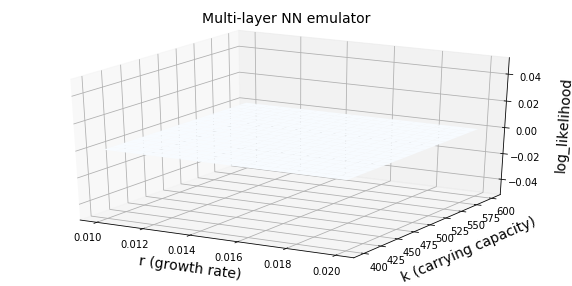

In [36]:
emu_prediction2 = pints.predict_grid(emu2, test_data)

plt.figure(figsize = (10, 5))
ax = surface(r_grid, k_grid, emu_prediction2, title = "Multi-layer NN emulator",
             x_label = "r (growth rate)", y_label = "k (carrying capacity)")

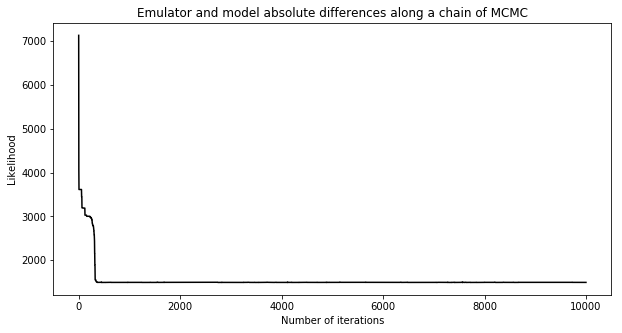

1493.7808704722418
[False False False ... False False False]


In [37]:
chain = chains[0]
emu_prediction2 = np.apply_along_axis(emu2, 1, chain).flatten()
model_prediction2 = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs2 = np.abs(model_prediction2 - emu_prediction2)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs2, color = "Black")
plt.show()
print(diffs2[-1])
print(diffs == diffs2)

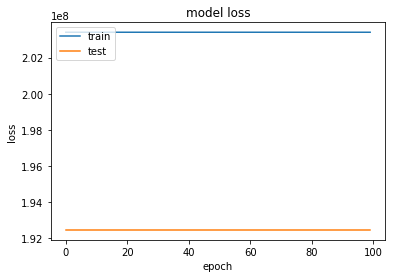

In [38]:
# summarize history for loss
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#print(hist.history['loss'])
#print(hist.history['val_loss'])

In [138]:
import pints
import numpy as np
import tensorflow as tf
import keras
import copy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau

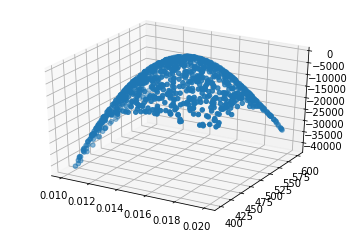

In [111]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(1000)
xs = [p[0] for p in input_parameters]
ys = [p[1] for p in input_parameters]
#input_parameters[:5]
input_parameters.shape

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, list(likelihoods))
plt.show()

In [179]:
from sklearn.preprocessing import MinMaxScaler
X = np.stack([xs, ys], axis=1)
y = likelihoods
n_train = int(0.8*len(y))

X_train = X[:n_train]
X_val = X[n_train:]
y_train = y[:n_train]
y_val = y[n_train:]

# create scaler
scaler = MinMaxScaler()
# fit scaler on data
scaler.fit(X_train)
# apply transform
X_train_n = scaler.transform(X_train)
X_val_n = scaler.transform(X_val)

In [187]:
# prepare dataset with input and output scalers, can be none
def get_dataset(input_scaler, output_scaler):
    # generate dataset
    X = log_prior.sample(1000)
    y = np.apply_along_axis(log_likelihood, 1, X)
    # split into train and test
    n_train = 800
    trainX, testX = X[:n_train, :], X[n_train:, :]
    trainy, testy = y[:n_train], y[n_train:]
    # scale inputs
    if input_scaler is not None:
        # fit scaler
        input_scaler.fit(trainX)
        # transform training dataset
        trainX = input_scaler.transform(trainX)
        # transform test dataset
        testX = input_scaler.transform(testX)
    if output_scaler is not None:
        # reshape 1d arrays to 2d arrays
        trainy = trainy.reshape(len(trainy), 1)
        testy = testy.reshape(len(testy), 1)
        # fit scaler on training dataset
        output_scaler.fit(trainy)
        # transform training dataset
        trainy = output_scaler.transform(trainy)
        # transform test dataset
        testy = output_scaler.transform(testy)
    return trainX, trainy, testX, testy

# fit and evaluate mse of model on test set
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	model = Sequential()
	model.add(Dense(25, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.01, momentum=0.9))
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	# evaluate the model
	test_mse = model.evaluate(testX, testy, verbose=0)
	return test_mse

# evaluate model multiple times with given input and output scalers
def repeated_evaluation(input_scaler, output_scaler, n_repeats=5):
	# get dataset
	trainX, trainy, testX, testy = get_dataset(input_scaler, output_scaler)
	# repeated evaluation of model
	results = list()
	for _ in range(n_repeats):
		test_mse = evaluate_model(trainX, trainy, testX, testy)
		print('>%.3f' % test_mse)
		results.append(test_mse)
	return results

Unscaled inputs
>1.021
>1.832
>1.832
>1.832
>1.832
Normalized inputs
>0.909
>0.747
>0.779
>0.778
>0.817
Standardized inputs
>0.809
>0.810
>0.810
>0.810
>0.810
Unscaled: 1.670 (0.325)
Normalized: 0.806 (0.056)
Standardized: 0.810 (0.000)


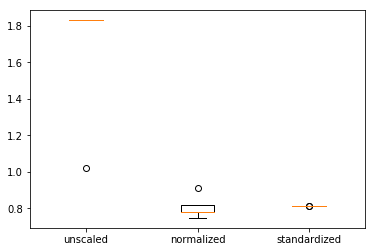

In [188]:
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from matplotlib import pyplot
from numpy import mean, std

# unscaled inputs
print("Unscaled inputs")
results_unscaled_inputs = repeated_evaluation(None, StandardScaler())
# normalized inputs
print("Normalized inputs")
results_normalized_inputs = repeated_evaluation(MinMaxScaler(), StandardScaler())
# standardized inputs
print("Standardized inputs")
results_standardized_inputs = repeated_evaluation(StandardScaler(), StandardScaler())
# summarize results
print('Unscaled: %.3f (%.3f)' % (mean(results_unscaled_inputs), std(results_unscaled_inputs)))
print('Normalized: %.3f (%.3f)' % (mean(results_normalized_inputs), std(results_normalized_inputs)))
print('Standardized: %.3f (%.3f)' % (mean(results_standardized_inputs), std(results_standardized_inputs)))
# plot results
results = [results_unscaled_inputs, results_normalized_inputs, results_standardized_inputs]
labels = ['unscaled', 'normalized', 'standardized']
pyplot.boxplot(results, labels=labels)
pyplot.show()

In [171]:
model = Sequential()
model.add(Dense(128,
                activation='relu',
                input_shape=(2,),
                kernel_initializer='normal',
                kernel_regularizer=tf.keras.regularizers.l2(0.2),
))
#model.add(Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))  # output layer

opt = keras.optimizers.adam(lr=0.000001)
#opt = SGD(lr=0.1, momentum=0.9) 
#opt = SGD(lr=0.1, momentum=0.9)
model.compile(
    loss='mae',
    #optimizer='adam'
    optimizer=opt,
    metrics=['mse','mae']
)

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)
history = model.fit(X_train_n,
                    likelihoods,
                    epochs=1000,
                    batch_size=32,
                    validation_split=0.2,
                    shuffle=True,
                    callbacks=[rlrop]
)


Train on 800 samples, validate on 200 samples
Epoch 1/1000
800/800 [==============================] - 1s 2ms/step - loss: 11832.8706 - mean_squared_error: 210448937.6000 - mean_absolute_error: 11832.7173 - val_loss: 11134.2851 - val_mean_squared_error: 180773957.7600 - val_mean_absolute_error: 11134.1318
Epoch 2/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8706 - mean_squared_error: 210448937.2800 - mean_absolute_error: 11832.7173 - val_loss: 11134.2851 - val_mean_squared_error: 180773955.2000 - val_mean_absolute_error: 11134.1318
Epoch 3/1000
800/800 [==============================] - 0s 47us/step - loss: 11832.8706 - mean_squared_error: 210448931.2000 - mean_absolute_error: 11832.7173 - val_loss: 11134.2851 - val_mean_squared_error: 180773955.2000 - val_mean_absolute_error: 11134.1318
Epoch 4/1000
800/800 [==============================] - 0s 49us/step - loss: 11832.8707 - mean_squared_error: 210448936.0000 - mean_absolute_error: 11832.7174 - val_loss: 1

800/800 [==============================] - 0s 47us/step - loss: 11832.8661 - mean_squared_error: 210448912.3200 - mean_absolute_error: 11832.7162 - val_loss: 11134.2800 - val_mean_squared_error: 180773934.0800 - val_mean_absolute_error: 11134.1306
Epoch 33/1000
800/800 [==============================] - 0s 46us/step - loss: 11832.8655 - mean_squared_error: 210448910.0800 - mean_absolute_error: 11832.7161 - val_loss: 11134.2800 - val_mean_squared_error: 180773934.0800 - val_mean_absolute_error: 11134.1306
Epoch 34/1000
800/800 [==============================] - 0s 44us/step - loss: 11832.8656 - mean_squared_error: 210448908.8000 - mean_absolute_error: 11832.7162 - val_loss: 11134.2799 - val_mean_squared_error: 180773928.9600 - val_mean_absolute_error: 11134.1305
Epoch 35/1000
800/800 [==============================] - 0s 43us/step - loss: 11832.8657 - mean_squared_error: 210448909.7600 - mean_absolute_error: 11832.7163 - val_loss: 11134.2799 - val_mean_squared_error: 180773927.6800 - va

800/800 [==============================] - 0s 45us/step - loss: 11832.8614 - mean_squared_error: 210448879.3600 - mean_absolute_error: 11832.7149 - val_loss: 11134.2754 - val_mean_squared_error: 180773911.6800 - val_mean_absolute_error: 11134.1289
Epoch 64/1000
800/800 [==============================] - 0s 45us/step - loss: 11832.8615 - mean_squared_error: 210448881.9200 - mean_absolute_error: 11832.7150 - val_loss: 11134.2754 - val_mean_squared_error: 180773909.1200 - val_mean_absolute_error: 11134.1289
Epoch 65/1000
800/800 [==============================] - 0s 44us/step - loss: 11832.8615 - mean_squared_error: 210448876.4800 - mean_absolute_error: 11832.7150 - val_loss: 11134.2750 - val_mean_squared_error: 180773909.1200 - val_mean_absolute_error: 11134.1286
Epoch 66/1000
800/800 [==============================] - 0s 45us/step - loss: 11832.8612 - mean_squared_error: 210448873.6000 - mean_absolute_error: 11832.7147 - val_loss: 11134.2750 - val_mean_squared_error: 180773906.5600 - va

Epoch 94/1000
800/800 [==============================] - 0s 50us/step - loss: 11832.8575 - mean_squared_error: 210448847.6800 - mean_absolute_error: 11832.7139 - val_loss: 11134.2713 - val_mean_squared_error: 180773882.2400 - val_mean_absolute_error: 11134.1277
Epoch 95/1000
800/800 [==============================] - 0s 45us/step - loss: 11832.8574 - mean_squared_error: 210448853.4400 - mean_absolute_error: 11832.7138 - val_loss: 11134.2713 - val_mean_squared_error: 180773882.2400 - val_mean_absolute_error: 11134.1277
Epoch 96/1000
800/800 [==============================] - 0s 46us/step - loss: 11832.8571 - mean_squared_error: 210448847.6800 - mean_absolute_error: 11832.7136 - val_loss: 11134.2713 - val_mean_squared_error: 180773882.2400 - val_mean_absolute_error: 11134.1277
Epoch 97/1000
800/800 [==============================] - 0s 49us/step - loss: 11832.8564 - mean_squared_error: 210448845.4400 - mean_absolute_error: 11832.7135 - val_loss: 11134.2703 - val_mean_squared_error: 18077

Epoch 125/1000
800/800 [==============================] - 0s 48us/step - loss: 11832.8531 - mean_squared_error: 210448824.3200 - mean_absolute_error: 11832.7125 - val_loss: 11134.2662 - val_mean_squared_error: 180773856.0000 - val_mean_absolute_error: 11134.1266
Epoch 126/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8521 - mean_squared_error: 210448823.0400 - mean_absolute_error: 11832.7125 - val_loss: 11134.2662 - val_mean_squared_error: 180773856.0000 - val_mean_absolute_error: 11134.1266
Epoch 127/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8519 - mean_squared_error: 210448820.4800 - mean_absolute_error: 11832.7123 - val_loss: 11134.2662 - val_mean_squared_error: 180773856.0000 - val_mean_absolute_error: 11134.1266
Epoch 128/1000
800/800 [==============================] - 0s 47us/step - loss: 11832.8520 - mean_squared_error: 210448816.6400 - mean_absolute_error: 11832.7123 - val_loss: 11134.2662 - val_mean_squared_error: 1

800/800 [==============================] - 0s 44us/step - loss: 11832.8480 - mean_squared_error: 210448791.3600 - mean_absolute_error: 11832.7113 - val_loss: 11134.2621 - val_mean_squared_error: 180773824.0000 - val_mean_absolute_error: 11134.1254
Epoch 157/1000
800/800 [==============================] - 0s 45us/step - loss: 11832.8480 - mean_squared_error: 210448792.3200 - mean_absolute_error: 11832.7113 - val_loss: 11134.2621 - val_mean_squared_error: 180773824.0000 - val_mean_absolute_error: 11134.1254
Epoch 158/1000
800/800 [==============================] - 0s 49us/step - loss: 11832.8479 - mean_squared_error: 210448796.8000 - mean_absolute_error: 11832.7112 - val_loss: 11134.2620 - val_mean_squared_error: 180773822.7200 - val_mean_absolute_error: 11134.1252
Epoch 159/1000
800/800 [==============================] - 0s 44us/step - loss: 11832.8480 - mean_squared_error: 210448791.6800 - mean_absolute_error: 11832.7113 - val_loss: 11134.2620 - val_mean_squared_error: 180773822.7200 -

Epoch 187/1000
800/800 [==============================] - 0s 48us/step - loss: 11832.8438 - mean_squared_error: 210448767.3600 - mean_absolute_error: 11832.7100 - val_loss: 11134.2579 - val_mean_squared_error: 180773797.7600 - val_mean_absolute_error: 11134.1241
Epoch 188/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8437 - mean_squared_error: 210448762.8800 - mean_absolute_error: 11832.7099 - val_loss: 11134.2579 - val_mean_squared_error: 180773795.2000 - val_mean_absolute_error: 11134.1241
Epoch 189/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8437 - mean_squared_error: 210448762.5600 - mean_absolute_error: 11832.7099 - val_loss: 11134.2579 - val_mean_squared_error: 180773793.9200 - val_mean_absolute_error: 11134.1241
Epoch 190/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8437 - mean_squared_error: 210448762.5600 - mean_absolute_error: 11832.7099 - val_loss: 11134.2579 - val_mean_squared_error: 1

800/800 [==============================] - 0s 47us/step - loss: 11832.8397 - mean_squared_error: 210448734.7200 - mean_absolute_error: 11832.7089 - val_loss: 11134.2537 - val_mean_squared_error: 180773767.6800 - val_mean_absolute_error: 11134.1228
Epoch 219/1000
800/800 [==============================] - 0s 51us/step - loss: 11832.8395 - mean_squared_error: 210448735.0400 - mean_absolute_error: 11832.7087 - val_loss: 11134.2537 - val_mean_squared_error: 180773767.6800 - val_mean_absolute_error: 11134.1228
Epoch 220/1000
800/800 [==============================] - 0s 46us/step - loss: 11832.8396 - mean_squared_error: 210448734.0800 - mean_absolute_error: 11832.7087 - val_loss: 11134.2535 - val_mean_squared_error: 180773767.6800 - val_mean_absolute_error: 11134.1227
Epoch 221/1000
800/800 [==============================] - 0s 47us/step - loss: 11832.8394 - mean_squared_error: 210448735.0400 - mean_absolute_error: 11832.7085 - val_loss: 11134.2535 - val_mean_squared_error: 180773767.6800 -

800/800 [==============================] - 0s 46us/step - loss: 11832.8354 - mean_squared_error: 210448708.4800 - mean_absolute_error: 11832.7075 - val_loss: 11134.2493 - val_mean_squared_error: 180773742.7200 - val_mean_absolute_error: 11134.1213
Epoch 250/1000
800/800 [==============================] - 0s 45us/step - loss: 11832.8353 - mean_squared_error: 210448706.8800 - mean_absolute_error: 11832.7074 - val_loss: 11134.2493 - val_mean_squared_error: 180773742.7200 - val_mean_absolute_error: 11134.1213
Epoch 251/1000
800/800 [==============================] - 0s 48us/step - loss: 11832.8352 - mean_squared_error: 210448706.5600 - mean_absolute_error: 11832.7072 - val_loss: 11134.2493 - val_mean_squared_error: 180773742.7200 - val_mean_absolute_error: 11134.1213
Epoch 252/1000
800/800 [==============================] - 0s 43us/step - loss: 11832.8352 - mean_squared_error: 210448705.9200 - mean_absolute_error: 11832.7073 - val_loss: 11134.2493 - val_mean_squared_error: 180773742.7200 -

800/800 [==============================] - 0s 46us/step - loss: 11832.8310 - mean_squared_error: 210448674.5600 - mean_absolute_error: 11832.7060 - val_loss: 11134.2451 - val_mean_squared_error: 180773707.5200 - val_mean_absolute_error: 11134.1201
Epoch 281/1000
800/800 [==============================] - 0s 46us/step - loss: 11832.8313 - mean_squared_error: 210448677.7600 - mean_absolute_error: 11832.7063 - val_loss: 11134.2450 - val_mean_squared_error: 180773707.5200 - val_mean_absolute_error: 11134.1200
Epoch 282/1000
800/800 [==============================] - 0s 41us/step - loss: 11832.8310 - mean_squared_error: 210448673.9200 - mean_absolute_error: 11832.7060 - val_loss: 11134.2450 - val_mean_squared_error: 180773707.5200 - val_mean_absolute_error: 11134.1200
Epoch 283/1000
800/800 [==============================] - 0s 46us/step - loss: 11832.8309 - mean_squared_error: 210448673.9200 - mean_absolute_error: 11832.7059 - val_loss: 11134.2449 - val_mean_squared_error: 180773704.9600 -

800/800 [==============================] - 0s 45us/step - loss: 11832.8268 - mean_squared_error: 210448645.4400 - mean_absolute_error: 11832.7047 - val_loss: 11134.2410 - val_mean_squared_error: 180773680.6400 - val_mean_absolute_error: 11134.1189
Epoch 312/1000
800/800 [==============================] - 0s 43us/step - loss: 11832.8270 - mean_squared_error: 210448647.0400 - mean_absolute_error: 11832.7049 - val_loss: 11134.2410 - val_mean_squared_error: 180773680.6400 - val_mean_absolute_error: 11134.1189
Epoch 313/1000
800/800 [==============================] - 0s 44us/step - loss: 11832.8268 - mean_squared_error: 210448648.3200 - mean_absolute_error: 11832.7048 - val_loss: 11134.2410 - val_mean_squared_error: 180773680.6400 - val_mean_absolute_error: 11134.1189
Epoch 314/1000
800/800 [==============================] - 0s 43us/step - loss: 11832.8267 - mean_squared_error: 210448646.0800 - mean_absolute_error: 11832.7046 - val_loss: 11134.2410 - val_mean_squared_error: 180773680.6400 -

800/800 [==============================] - 0s 45us/step - loss: 11832.8232 - mean_squared_error: 210448613.1200 - mean_absolute_error: 11832.7031 - val_loss: 11134.2374 - val_mean_squared_error: 180773649.9200 - val_mean_absolute_error: 11134.1173
Epoch 343/1000
800/800 [==============================] - 0s 47us/step - loss: 11832.8236 - mean_squared_error: 210448611.8400 - mean_absolute_error: 11832.7035 - val_loss: 11134.2374 - val_mean_squared_error: 180773649.9200 - val_mean_absolute_error: 11134.1173
Epoch 344/1000
800/800 [==============================] - 0s 46us/step - loss: 11832.8227 - mean_squared_error: 210448611.8400 - mean_absolute_error: 11832.7034 - val_loss: 11134.2362 - val_mean_squared_error: 180773648.6400 - val_mean_absolute_error: 11134.1171
Epoch 345/1000
800/800 [==============================] - 0s 47us/step - loss: 11832.8225 - mean_squared_error: 210448613.4400 - mean_absolute_error: 11832.7034 - val_loss: 11134.2362 - val_mean_squared_error: 180773646.0800 -

800/800 [==============================] - 0s 30us/step - loss: 11832.8193 - mean_squared_error: 210448584.0000 - mean_absolute_error: 11832.7021 - val_loss: 11134.2330 - val_mean_squared_error: 180773621.7600 - val_mean_absolute_error: 11134.1159
Epoch 374/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8193 - mean_squared_error: 210448583.3600 - mean_absolute_error: 11832.7021 - val_loss: 11134.2330 - val_mean_squared_error: 180773621.7600 - val_mean_absolute_error: 11134.1159
Epoch 375/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8191 - mean_squared_error: 210448583.0400 - mean_absolute_error: 11832.7019 - val_loss: 11134.2330 - val_mean_squared_error: 180773621.7600 - val_mean_absolute_error: 11134.1159
Epoch 376/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8192 - mean_squared_error: 210448577.9200 - mean_absolute_error: 11832.7020 - val_loss: 11134.2330 - val_mean_squared_error: 180773616.6400 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8151 - mean_squared_error: 210448552.3200 - mean_absolute_error: 11832.7008 - val_loss: 11134.2291 - val_mean_squared_error: 180773589.7600 - val_mean_absolute_error: 11134.1148
Epoch 405/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8148 - mean_squared_error: 210448551.0400 - mean_absolute_error: 11832.7005 - val_loss: 11134.2291 - val_mean_squared_error: 180773585.9200 - val_mean_absolute_error: 11134.1148
Epoch 406/1000
800/800 [==============================] - 0s 50us/step - loss: 11832.8149 - mean_squared_error: 210448554.5600 - mean_absolute_error: 11832.7007 - val_loss: 11134.2291 - val_mean_squared_error: 180773585.9200 - val_mean_absolute_error: 11134.1148
Epoch 407/1000
800/800 [==============================] - 0s 20us/step - loss: 11832.8150 - mean_squared_error: 210448547.8400 - mean_absolute_error: 11832.7008 - val_loss: 11134.2291 - val_mean_squared_error: 180773585.9200 -

Epoch 435/1000
800/800 [==============================] - 0s 31us/step - loss: 11832.8116 - mean_squared_error: 210448520.9600 - mean_absolute_error: 11832.6993 - val_loss: 11134.2255 - val_mean_squared_error: 180773555.2000 - val_mean_absolute_error: 11134.1132
Epoch 436/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8114 - mean_squared_error: 210448517.1200 - mean_absolute_error: 11832.6993 - val_loss: 11134.2246 - val_mean_squared_error: 180773555.2000 - val_mean_absolute_error: 11134.1132
Epoch 437/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8105 - mean_squared_error: 210448519.0400 - mean_absolute_error: 11832.6992 - val_loss: 11134.2246 - val_mean_squared_error: 180773552.6400 - val_mean_absolute_error: 11134.1132
Epoch 438/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8104 - mean_squared_error: 210448519.6800 - mean_absolute_error: 11832.6990 - val_loss: 11134.2246 - val_mean_squared_error: 1

Epoch 466/1000
800/800 [==============================] - 0s 41us/step - loss: 11832.8072 - mean_squared_error: 210448488.0000 - mean_absolute_error: 11832.6978 - val_loss: 11134.2211 - val_mean_squared_error: 180773528.3200 - val_mean_absolute_error: 11134.1118
Epoch 467/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8071 - mean_squared_error: 210448486.7200 - mean_absolute_error: 11832.6978 - val_loss: 11134.2211 - val_mean_squared_error: 180773528.3200 - val_mean_absolute_error: 11134.1118
Epoch 468/1000
800/800 [==============================] - 0s 44us/step - loss: 11832.8071 - mean_squared_error: 210448480.6400 - mean_absolute_error: 11832.6977 - val_loss: 11134.2211 - val_mean_squared_error: 180773528.3200 - val_mean_absolute_error: 11134.1118
Epoch 469/1000
800/800 [==============================] - 0s 41us/step - loss: 11832.8073 - mean_squared_error: 210448483.2000 - mean_absolute_error: 11832.6979 - val_loss: 11134.2211 - val_mean_squared_error: 1

800/800 [==============================] - 0s 39us/step - loss: 11832.8045 - mean_squared_error: 210448463.6800 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 498/1000
800/800 [==============================] - 0s 52us/step - loss: 11832.8042 - mean_squared_error: 210448465.2800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 499/1000
800/800 [==============================] - 0s 38us/step - loss: 11832.8043 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 500/1000
800/800 [==============================] - 0s 37us/step - loss: 11832.8044 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448465.2800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 529/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 530/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8041 - mean_squared_error: 210448462.7200 - mean_absolute_error: 11832.6967 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 531/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8040 - mean_squared_error: 210448461.1200 - mean_absolute_error: 11832.6966 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

Epoch 559/1000
800/800 [==============================] - 0s 45us/step - loss: 11832.8042 - mean_squared_error: 210448462.7200 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 560/1000
800/800 [==============================] - 0s 42us/step - loss: 11832.8042 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 561/1000
800/800 [==============================] - 0s 41us/step - loss: 11832.8042 - mean_squared_error: 210448464.6400 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 562/1000
800/800 [==============================] - 0s 33us/step - loss: 11832.8041 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6966 - val_loss: 11134.2184 - val_mean_squared_error: 1

800/800 [==============================] - 0s 20us/step - loss: 11832.8044 - mean_squared_error: 210448464.6400 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 591/1000
800/800 [==============================] - 0s 19us/step - loss: 11832.8043 - mean_squared_error: 210448462.7200 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 592/1000
800/800 [==============================] - ETA: 0s - loss: 11663.2871 - mean_squared_error: 213111264.0000 - mean_absolute_error: 11663.17 - 0s 20us/step - loss: 11832.8043 - mean_squared_error: 210448461.1200 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 593/1000
800/800 [==============================] - 0s 54us/step - loss: 11832.8043 - mean_squared_error: 210448464.0000 -

Epoch 621/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448460.8000 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 622/1000
800/800 [==============================] - 0s 20us/step - loss: 11832.8044 - mean_squared_error: 210448462.4000 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 623/1000
800/800 [==============================] - 0s 53us/step - loss: 11832.8045 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 624/1000
800/800 [==============================] - 0s 53us/step - loss: 11832.8042 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 1

Epoch 652/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448465.9200 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 653/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448461.4400 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 654/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448464.0000 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 655/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 1

800/800 [==============================] - 0s 19us/step - loss: 11832.8042 - mean_squared_error: 210448460.1600 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 684/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448460.1600 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 685/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448459.5200 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 686/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448464.9600 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448460.8000 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 715/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448463.6800 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 716/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448464.0000 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 717/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448464.9600 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448468.4800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 746/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448466.5600 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 747/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8041 - mean_squared_error: 210448460.4800 - mean_absolute_error: 11832.6967 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 748/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448458.2400 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

Epoch 776/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 777/1000
800/800 [==============================] - 0s 20us/step - loss: 11832.8041 - mean_squared_error: 210448463.6800 - mean_absolute_error: 11832.6967 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 778/1000
800/800 [==============================] - 0s 20us/step - loss: 11832.8043 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 779/1000
800/800 [==============================] - 0s 20us/step - loss: 11832.8044 - mean_squared_error: 210448461.1200 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 1

800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448465.6000 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 808/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448464.9600 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 809/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8041 - mean_squared_error: 210448460.1600 - mean_absolute_error: 11832.6967 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 810/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448464.3200 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448464.6400 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 839/1000
800/800 [==============================] - 0s 49us/step - loss: 11832.8042 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 840/1000
800/800 [==============================] - 0s 38us/step - loss: 11832.8043 - mean_squared_error: 210448463.0400 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 841/1000
800/800 [==============================] - 0s 40us/step - loss: 11832.8045 - mean_squared_error: 210448462.4000 - mean_absolute_error: 11832.6971 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8045 - mean_squared_error: 210448463.0400 - mean_absolute_error: 11832.6971 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 869/1000
800/800 [==============================] - 0s 61us/step - loss: 11832.8042 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 870/1000
800/800 [==============================] - 0s 44us/step - loss: 11832.8043 - mean_squared_error: 210448464.3200 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 871/1000
800/800 [==============================] - 0s 46us/step - loss: 11832.8042 - mean_squared_error: 210448459.5200 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 51us/step - loss: 11832.8044 - mean_squared_error: 210448464.0000 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 900/1000
800/800 [==============================] - 0s 54us/step - loss: 11832.8042 - mean_squared_error: 210448464.0000 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 901/1000
800/800 [==============================] - 0s 43us/step - loss: 11832.8043 - mean_squared_error: 210448465.9200 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 902/1000
800/800 [==============================] - 0s 44us/step - loss: 11832.8043 - mean_squared_error: 210448465.2800 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 931/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8041 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6967 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 932/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8044 - mean_squared_error: 210448462.0800 - mean_absolute_error: 11832.6970 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 933/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448462.7200 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448465.6000 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 962/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448465.9200 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 963/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448463.6800 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 964/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 -

Epoch 992/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448463.0400 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 993/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448465.9200 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 994/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8042 - mean_squared_error: 210448464.0000 - mean_absolute_error: 11832.6968 - val_loss: 11134.2184 - val_mean_squared_error: 180773516.8000 - val_mean_absolute_error: 11134.1109
Epoch 995/1000
800/800 [==============================] - 0s 39us/step - loss: 11832.8043 - mean_squared_error: 210448463.3600 - mean_absolute_error: 11832.6969 - val_loss: 11134.2184 - val_mean_squared_error: 1

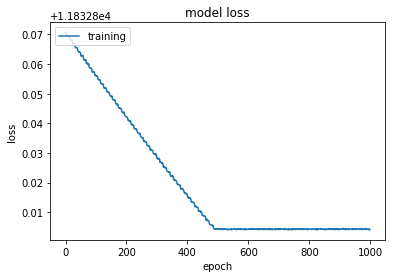

In [172]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training'], loc='upper left')
plt.show()
#print(hist.history['loss'])
#print(hist.history['val_loss'])